<h1><center> COMPUTATIONAL FINANCE </center></h1> 
<h5><center> Francisco Ramalho </center></h5> 
<h5><center> Nov 2020 </center></h5> 
<h1><center> This notebook presents a simple exercise of Computanional Finance </center></h1>
<h3> Considering the following market data for bond yields </h3>


In [1]:
dates = ['09-10-2020', '09-09-2020', '07-08-2020', '09-07-2020', '09-06-2020']
tenors = ['3M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
data = [
    [-0.545, -0.529, -0.523, -0.604, -0.471, -0.436, -0.329, -0.237, -0.118, -0.05 ,  0.013,  0.155,  0.505,  0.525,  0.854],
    [-0.504, -0.499, -0.499, -0.561, -0.386, -0.327, -0.179, -0.097, 0.076,  0.161,  0.222,  0.359,  0.718,  0.748,  1.069],
    [-0.502, -0.491, -0.476, -0.462, -0.328, -0.319, -0.209, -0.142, 0.02 ,  0.108,  0.167,  0.293,  0.639,  0.682,  1.011],
    [-0.462, -0.459, -0.447, -0.485, -0.35 , -0.31 , -0.114, -0.053, 0.139,  0.241,  0.307,  0.412,  0.777,  0.828,  1.161],
    [-0.455, -0.446, -0.421, -0.352, -0.235, -0.196,  0.058,  0.138, 0.23 ,  0.418,  0.485,  0.59 ,  0.851,  1.049,  1.427]
]

<h3> The exercise consists of: </h3>
<h5> a) Building a pandas DataFrame with the data using the dates as columns and year fractions of the tenors as index </h5>
<h5> b) Plotting the yield curve for each date </h5>
<h5> c) Estimating the NSS parameters for each date</h5>
<h5> d) Plotting the NSS Yield Curve for each date </h5>
<h5> e) Plotting the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor) </h5>
<h5> f) Plotting the market data points vs the NSS fit for each date using 5 subplots sharing the y axis (One market date in each subplot) </h5>
<h5> g) Making a function that gives the daycount fraction between two dates for either convention Act/360 or Act/365 using date strings as inputs </h5>
<h5> h) Making a function that returns the present value of a future investment for a given rate and using it to determine the present value of a payment of EUR 2,430.04 in 5 years at the rate of 5% (Annual compounded rate) </h5>


-------------------------------------------------------------

# a) Building a pandas DataFrame with the data using the dates as columns and year fractions of the tenors as index

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime

In [3]:
def Convert_to_yearfrac(tenors):
    tenor_yearfrac=np.empty(0)
    for tenor in tenors:
        if 'M' in tenor:
            tenor=tenor[:-1]
            tenor_yearfrac=np.append(tenor_yearfrac,float(tenor)/12)
        if 'Y' in tenor:
            tenor=tenor[:-1]
            tenor_yearfrac=np.append(tenor_yearfrac,float(tenor))
    return tenor_yearfrac

In [4]:
tenors_yearfrac=Convert_to_yearfrac(tenors)
tenors_yearfrac

array([ 0.25,  0.5 ,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,
        8.  ,  9.  , 10.  , 15.  , 20.  , 30.  ])

In [5]:
YieldCurveData=pd.DataFrame(np.array(data).T,index=tenors_yearfrac,columns=dates)
YieldCurveData

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
0.25,-0.545,-0.504,-0.502,-0.462,-0.455
0.50,-0.529,-0.499,-0.491,-0.459,-0.446
1.00,-0.523,-0.499,-0.476,-0.447,-0.421
2.00,-0.604,-0.561,-0.462,-0.485,-0.352
3.00,-0.471,-0.386,-0.328,-0.350,-0.235
4.00,-0.436,-0.327,-0.319,-0.310,-0.196
5.00,-0.329,-0.179,-0.209,-0.114,0.058
6.00,-0.237,-0.097,-0.142,-0.053,0.138
7.00,-0.118,0.076,0.020,0.139,0.230
8.00,-0.050,0.161,0.108,0.241,0.418


### b) Ploting the yield curve for each date

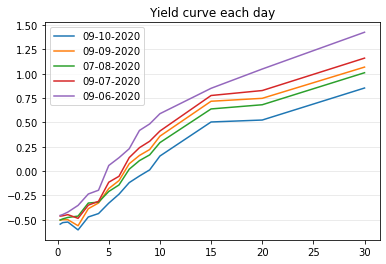

In [6]:
fig1, ax1 = plt.subplots()
for date in dates:
    ax1=YieldCurveData[date].plot()
ax1.legend();
ax1.set(title='Yield curve each day');
ax1.grid(alpha=0.3, axis='y');

### c) Estimating the NSS parameters for each date

##### NSS function calculate the spot rate for a given set of parameters (p) and the desired maturity (term)

In [7]:
def NSS(p, term):
    beta0, beta1, beta2, beta3, tau1, tau2 = p
    return ( beta0
            +beta1*(1-np.exp(-term/tau1))/(term/tau1)
            +beta2*((1-np.exp(-term/tau1))/(term/tau1)-np.exp(-term/tau1))
            +beta3*((1-np.exp(-term/tau2))/(term/tau2)-np.exp(-term/tau2)))

def error(guess, x, y): return ((NSS(guess, x) - y)**2).sum()

NSS_Parameters=pd.DataFrame(index=["beta0", "beta1", "beta2", "beta3", "tau1", "tau2"], columns=dates)

##### Random initial guess for the NSS parameters

In [8]:
guess = np.array([1.5,  -2.00,  7.7, -10.99,  3.50, 3.80])
for date in dates:
    x=tenors_yearfrac
    y=YieldCurveData[date]  
    NSS_Parameters[date]=minimize(error, guess, args=(x, y))['x']
NSS_Parameters

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
beta0,1.225925,1.410435,1.404120,1.510002,1.826035
beta1,-1.718157,-1.861669,-1.881936,-1.915742,-2.281718
beta2,8.160337,7.997013,8.391830,8.002822,8.168175
beta3,-10.513431,-10.658075,-10.285499,-10.654758,-10.502438
tau1,3.093738,2.521171,3.689039,2.633432,3.050768
tau2,3.052569,2.521200,3.568528,2.610151,3.050767


### d) Plotting the NSS Yield Curve for each date

In [9]:
NSS_curve=pd.DataFrame(index=tenors_yearfrac,columns=dates)
for date in dates:
    for tenor in tenors_yearfrac:
        NSS_curve.loc[[tenor],[date]]=NSS(NSS_Parameters[date],tenor)
NSS_curve

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
0.25,-0.519884,-0.485434,-0.487532,-0.439772,-0.455271
0.50,-0.540617,-0.50969,-0.492689,-0.463863,-0.450129
1.00,-0.564279,-0.533271,-0.491196,-0.487077,-0.42785
2.00,-0.557431,-0.508066,-0.451975,-0.460832,-0.347917
3.00,-0.503147,-0.42441,-0.380773,-0.375627,-0.239086
4.00,-0.422274,-0.31236,-0.291719,-0.261568,-0.116594
5.00,-0.328409,-0.189987,-0.194331,-0.136855,0.009782
6.00,-0.230225,-0.06777,-0.094879,-0.012108,0.133974
7.00,-0.133076,0.048565,0.002639,0.106824,0.252407
8.00,-0.04011,0.156204,0.095797,0.217035,0.363162


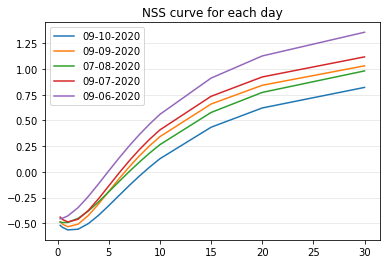

In [10]:
fig2, ax2 = plt.subplots() 
for date in dates:          
    ax2=NSS_curve[date].plot()
ax2.legend();
ax2.set(title='NSS curve for each day');
ax2.grid(alpha=0.3, axis='y');

### e) Plotting the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor)

In [11]:
tenors_to_plot=['9M','3.5Y','12.5Y','25Y']
tenors_to_plot_yearfrac=Convert_to_yearfrac(tenors_to_plot)
tenors_to_plot_yearfrac

array([ 0.75,  3.5 , 12.5 , 25.  ])

In [12]:
NSS_4tenors=pd.DataFrame(index=tenors_to_plot_yearfrac,columns=dates)
for date in dates:
    for tenor in tenors_to_plot_yearfrac:
        NSS_4tenors.loc[[tenor],[date]]=NSS(NSS_Parameters[date],tenor)
NSS_4tenors     

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
0.75,-0.555186,-0.525262,-0.493764,-0.47926,-0.44082
3.50,-0.465045,-0.370584,-0.337793,-0.320847,-0.178832
12.50,0.299224,0.523318,0.438953,0.59412,0.756961
25.00,0.739924,0.954473,0.896563,1.038941,1.263543


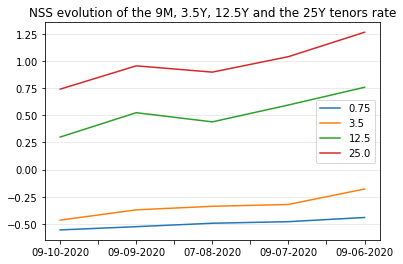

In [13]:
fig3, ax3 = plt.subplots()  #esta a imprimir 2 plots. Porque??????
NSS_4tenors.T.plot(ax=ax3);
ax3.legend();
ax3.set(title='NSS evolution of the 9M, 3.5Y, 12.5Y and the 25Y tenors rate');
ax3.grid(alpha=0.3, axis='y');

### f) Plotting the market data points vs the NSS fit for each date using 5 subplots sharing the y axis (One market date in each subplot)

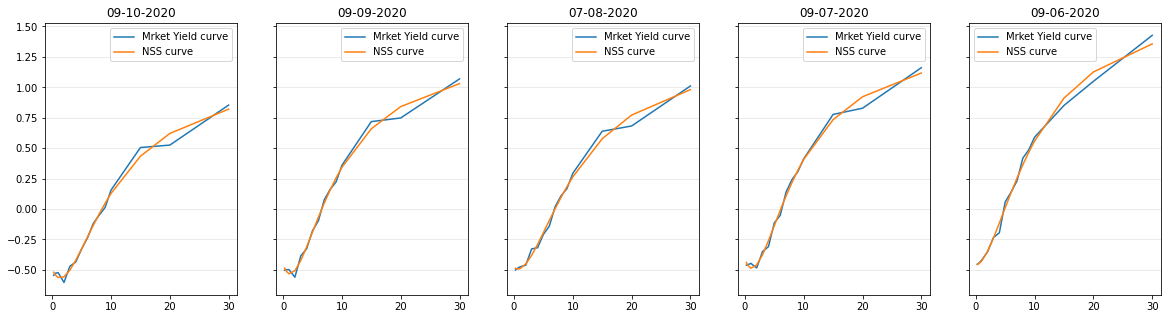

In [14]:
fig4, ax4 = plt.subplots(1,len(dates), figsize=(20,5), sharey=True)
for idx, date in enumerate(dates):
    YieldCurveData[date].plot(ax=ax4[idx],label='Mrket Yield curve');
    NSS_curve[date].plot(ax=ax4[idx],label='NSS curve');
    ax4[idx].set(title=date);
    ax4[idx].legend();
    ax4[idx].grid(alpha=0.3, axis='y');

### g) Making a function that will give the daycount fraction between two dates for either convention Act/360 or Act/365 using date strings as inputs.
### Example: dayCount('15-06-2020', '15-12-2021', 'Act/360')


In [15]:
def dayCount (date1,date2,convention):
    VecDate1=[x.strip() for x in date1.split('-')]
    VecDate2=[x.strip() for x in date2.split('-')]
    datefraction1=datetime.date(int(VecDate1[2]),int(VecDate1[1]),int(VecDate1[0]))
    datefraction2=datetime.date(int(VecDate2[2]),int(VecDate2[1]),int(VecDate2[0]))
    datefraction=(datefraction2-datefraction1).days
    
    if convention == 'Act/360':
        return datefraction/360
    if convention == 'Act/365':
        return datefraction/365
    else:
        return print("ERROR! Function only accepts Act/360 or Act/365")

In [16]:
dayCount('15-06-2020', '15-12-2021', 'Act/360')

1.5222222222222221

In [17]:
dayCount('15-06-2020', '15-12-2021', 'Act/365')

1.5013698630136987

In [18]:
dayCount('15-06-2020', '15-12-2021', '30/360')

ERROR! Function only accepts Act/360 or Act/365


### h) Making a function that returns the present value of a future investment for a given rate and using it to determine the present value of a payment of EUR 2,430.04 in 5 years at the rate of 5% (Annual compounded rate)


In [19]:
def pv(amount, rate, maturity):
    pv=amount/(1+rate)**(maturity)
    print(f"The present value of {amount} in {maturity} years assuming a {rate} annualy compounded rate is: {pv}")

In [20]:
pv (2430.04, 0.05, 5)

The present value of 2430.04 in 5 years assuming a 0.05 annualy compounded rate is: 1903.9999255650137
